# fBm field generation and testing

Translated and adapted from the Julia implementation:\

- [GaussianRandomFields.jl](https://github.com/PieterjanRobbe/GaussianRandomFields.jl)\
Original author:  Pieterjan Robbe \
License: MIT

## Stationary d-dimensional Gaussian random field generator using the circulant embedding method

In [1]:
import numpy as np
import warnings
from scipy.fft import fftn, dctn, next_fast_len
import matplotlib.pyplot as plt

class GaussianRandomFieldCircEmbed:
    """
    Gaussian random field via circulant embedding.
    """
    def __init__(self, mean, cov, pts,
                 minpadding=0):
        self.mean = mean
        self.cov  = cov
        self.pts  = pts
        
        normedpts = [p - p[0] for p in pts]
        
        # compute minimal circulant‐embedding size in each dim
        pad = minpadding
        if np.isscalar(pad):
            pads = [pad]*len(pts) # if minpadding is scalar, use same in each dim
        else:
            pads = pad
        dims = [
            self.circulant_minsize(cov, normedpts[i], pads[i])
            for i in range(len(pts))
        ]
        
        # compute the embedded covariance eigenvalues
        Λ = self.circulant_eigvals(cov, normedpts, dims)
        
        # zero out any small negative λ due to numerical error,
        #    track how many and how negative, then scale by sqrt(λ/M)
        M = np.prod(dims)
        neg_mask = Λ < 0
        n_neg = int(neg_mask.sum())
        λ_min = None
        if n_neg:
            λ_min = float(Λ[neg_mask].min())
            Λ[neg_mask] = 0.0
        pos_mask = ~neg_mask
        Λ[pos_mask] = np.sqrt(Λ[pos_mask] / M)
        
        if n_neg:
            warnings.warn(
                f"{n_neg} negative eigenvalues ≥ {λ_min:.3e} were set to zero; "
                "consider increasing padding."
            )
        
        # store data:  v = sqrt(eigs/M)  and  shape_emb = tuple(dims)
        self.data = (Λ, tuple(dims))
        
    def sample(self):
        """
        Single realization.  xi must be shape == self.data[1].
        """
        Λ, shape_emb = self.data
        xi = np.random.randn(*shape_emb)
        # 1) spectral weights
        w = Λ * xi
        # 2) forward FFT over all dims
        w = fftn(w)
        # 3) crop back to original grid and extract real+imag
        orig_shape = tuple(len(p) for p in self.pts)
        slices = tuple(slice(0, n) for n in orig_shape)
        w_crop = w[slices]
        return self.mean + (w_crop.real + w_crop.imag)

    @staticmethod
    def circulant_minsize(cov, pts, minpadding):
        n = len(pts)
        base = n + minpadding - (1 if cov.is_even else 0)
        return 2 * next_fast_len(base) # SciPy’s next_fast_len returns the smallest ≥ base with 2,3,5 factors

    @staticmethod
    def circulant_eigvals(cov, pts, dims):
        pts = [np.asarray(p) for p in pts]
        starts = [p[0] for p in pts]
        steps = [p[1] - p[0] for p in pts]
        N = len(dims)
        is_even = getattr(cov, 'is_even', False)
        
        # Vectorized covariance evaluation
        cov_vec = np.vectorize(cov, signature='(n)->()')
        
        if is_even:
            half_shape = tuple(d//2 + 1 for d in dims)
            coords = [starts[d] + np.arange(half_shape[d]) * steps[d] for d in range(N)]
            mesh = np.stack(np.meshgrid(*coords, indexing='ij'), axis=-1)
            C = cov_vec(mesh)
            C = dctn(C, type=1, norm=None)
            idx = [np.minimum(np.arange(d), d - np.arange(d)) for d in dims]
            mesh_idx = np.ix_(*idx)
            return C[mesh_idx]
        else:
            C = np.zeros(dims, dtype=float)
            dims2 = [d + 2 for d in dims]
            mids  = [d2 // 2 for d2 in dims2]
            grid = [np.arange(d) for d in dims]
            # Build signed offsets
            coords = []
            for d in range(N):
                idx = grid[d]
                pos = np.where(idx < mids[d], idx, idx - dims[d])
                coords.append(starts[d] + pos * steps[d])
            mesh = np.stack(np.meshgrid(*coords, indexing='ij'), axis=-1)
            mask = np.ones(dims, dtype=bool)
            for d in range(N):
                mask &= ((grid[d] + 1) != mids[d]).reshape(
                    *(dims[j] if j == d else 1 for j in range(N))
                )
            C[mask] = cov_vec(mesh[mask])
            return np.real(np.fft.fftn(C))

class PrefbmCov:
    def __init__(self, alpha):
        self.alpha = alpha
        self.is_even = True
    def __call__(self, x):
        r = np.linalg.norm(x)
        α = self.alpha
        if r == 0:
            return 1 - α/6 - α**2/6
        if r <= 1:
            return 1 - α/6 - α**2/6 - r**α + α*(5+2*α)*r**2/18
        elif r <= 2:
            return α*(2-α)/18 * (2-r)**3 / r
        else:
            return 0.0

class ExpCov:
    def __init__(self, sigma=1.0, length_scale=1.0):
        self.sigma = sigma
        self.length_scale = length_scale
        self.is_even = True
    def __call__(self, x):
        r = np.linalg.norm(x)
        return self.sigma**2 * np.exp(-np.abs(r) / self.length_scale)

## Generate a fBm field

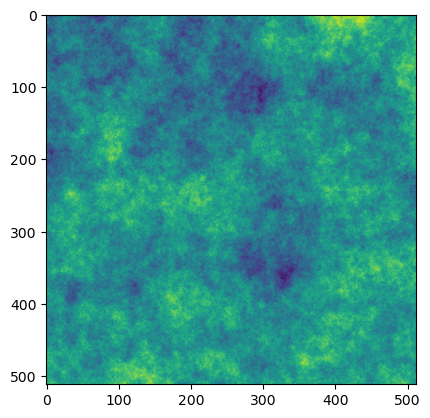

In [2]:
# Generate a sample of a stationary Gaussian random field with given mean and covariance function 
alpha = 0.5
num_pt = 512
cov = PrefbmCov(alpha)
pts=(np.linspace(0,1,num_pt),)*2
mean = np.zeros((num_pt,num_pt))
prefbm_gen = GaussianRandomFieldCircEmbed(mean, cov, pts, minpadding=256)
prefbm_field = prefbm_gen.sample()

# For prefbm covariance function, add a trend to the sample to make it a fbm field
c2 = alpha * (5 + 2 * alpha) / 18
sigma = np.sqrt(2 * c2)
coords = np.meshgrid(*pts, indexing="ij")
X = np.random.normal(loc=0.0, scale=sigma, size=len(coords))
trend = sum(xi_coord * Xi for xi_coord, Xi in zip(coords, X))
fbm_field = prefbm_field + trend

plt.imshow(fbm_field)

## Statistics test

### Generate an ensemble of fBm fields

In [ ]:
# Parameters
alpha = 0.5
num_pt = 512
num_mc = 100

# 2d axes
pts=(np.linspace(0,1,num_pt),)*2
orig_shape = tuple(len(p) for p in pts)
fields = np.empty((num_mc, *orig_shape))

# Initialize the generator
mean = np.zeros((num_pt,num_pt))
cov = PrefbmCov(alpha)
prefbm_gen = GaussianRandomFieldCircEmbed(mean, cov, pts, minpadding=256)

# Generate num_mc fbm fields
for i in range(num_mc):
    prefbm_field = prefbm_gen.sample()
    c2 = alpha * (5 + 2 * alpha) / 18
    sigma = np.sqrt(2 * c2)
    coords = np.meshgrid(*pts, indexing="ij")
    X = np.random.normal(loc=0.0, scale=sigma, size=len(coords))
    trend = sum(xi_coord * Xi for xi_coord, Xi in zip(coords, X))
    fields[i] = prefbm_field + trend

### Ensemble mean and variance

In [58]:
# ensemble mean at each gridpoint
mean_field = fields.mean(axis=0)

# ensemble variance at each gridpoint
var_field = fields.var(axis=0, ddof=1)


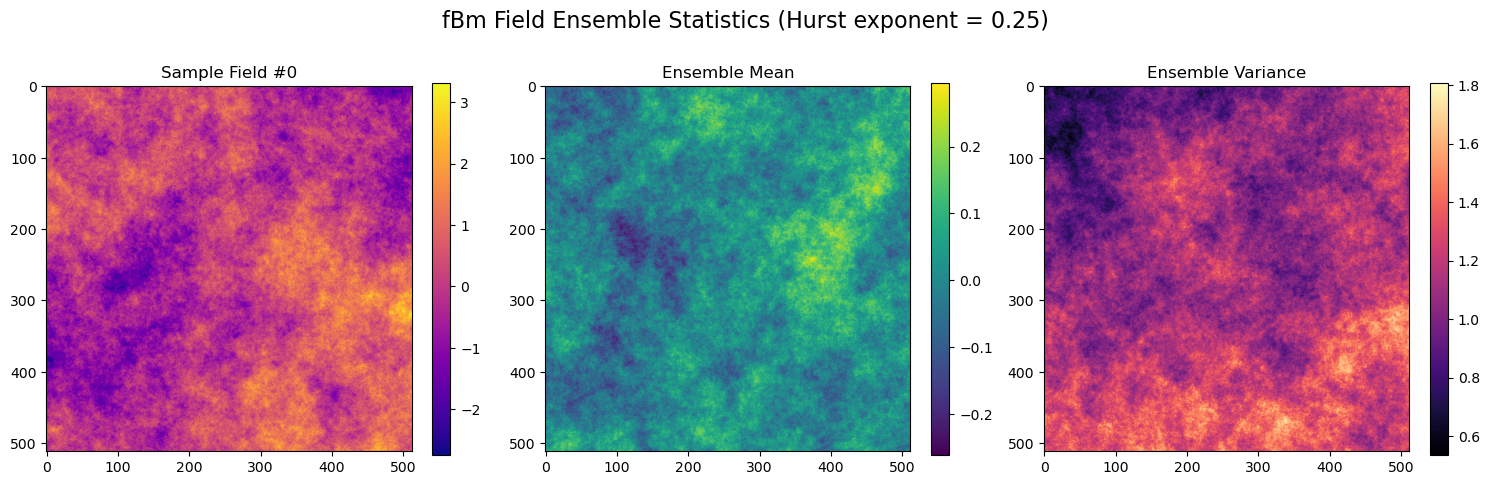

In [59]:
import matplotlib.pyplot as plt

# Choose a sample field (e.g., first one)
sample_idx = 0
sample_field = fields[sample_idx]

# Set up figure with 1 row, 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: A sample realization
im0 = axes[0].imshow(sample_field, cmap='plasma')
axes[0].set_title(f"Sample Field #{sample_idx}")
fig.colorbar(im0, ax=axes[0], fraction=0.046)

# Plot 2: Ensemble mean
im1 = axes[1].imshow(mean_field, cmap='viridis')
axes[1].set_title("Ensemble Mean")
fig.colorbar(im1, ax=axes[1], fraction=0.046)

# Plot 3: Ensemble variance
im2 = axes[2].imshow(var_field, cmap='magma')
axes[2].set_title("Ensemble Variance")
fig.colorbar(im2, ax=axes[2], fraction=0.046)

plt.suptitle(f"fBm Field Ensemble Statistics (Hurst exponent = {alpha/2})", fontsize=16)
plt.tight_layout()
plt.show()


### Ensemble variogram

In [60]:
max_lag = 300
lags = np.arange(1, max_lag+1)
gamma_iso = np.zeros_like(lags, dtype=float)

for idx, h in enumerate(lags):
    acc = []
    for d in range(fields.ndim-1):
        slicer1 = [slice(None)]*(fields.ndim)
        slicer2 = [slice(None)]*(fields.ndim)
        slicer1[d+1] = slice(0, -h)
        slicer2[d+1] = slice(h, None)
        diffs = fields[tuple(slicer1)] - fields[tuple(slicer2)]
        acc.append(diffs.ravel()**2)
    gamma_iso[idx] = np.mean(np.concatenate(acc)) / 2

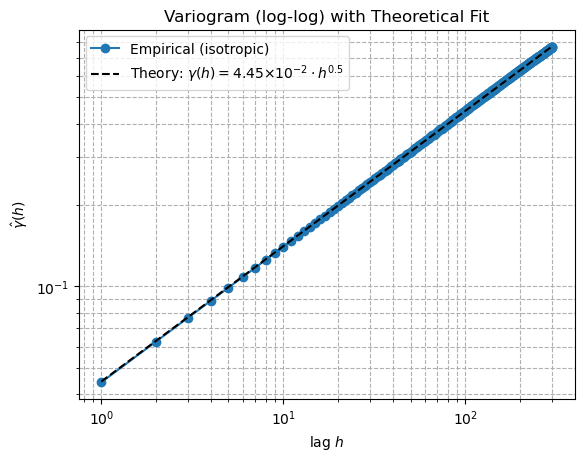

In [61]:
from scipy.stats import linregress

# Ensure positive values
valid = (gamma_iso > 0) & (lags > 0)
log_h = np.log(lags[valid])
log_gamma = np.log(gamma_iso[valid])
slope, intercept, *_ = linregress(log_h, log_gamma)

log_c = np.mean(log_gamma - alpha * log_h)
c_fitted = np.exp(log_c)
mantissa, exponent = f"{c_fitted:.2e}".split('e')

# Theoretical model
gamma_theory = c_fitted * lags**alpha

# Plotting
plt.figure()
plt.loglog(lags, gamma_iso, 'o-', label="Empirical (isotropic)")
plt.loglog(lags, gamma_theory, 'k--', label=fr"Theory: $\gamma(h) = {mantissa} × 10^{{{int(exponent)}}} \cdot h^{{{alpha}}}$")
plt.xlabel("lag $h$")
plt.ylabel(r"$\hat{\gamma}(h)$")
plt.title("Variogram (log-log) with Theoretical Fit")
plt.legend()
plt.grid(True, which="both", ls="--")
plt.savefig('variogram.pdf', format='pdf')
plt.show()

### Save all plots as a pdf

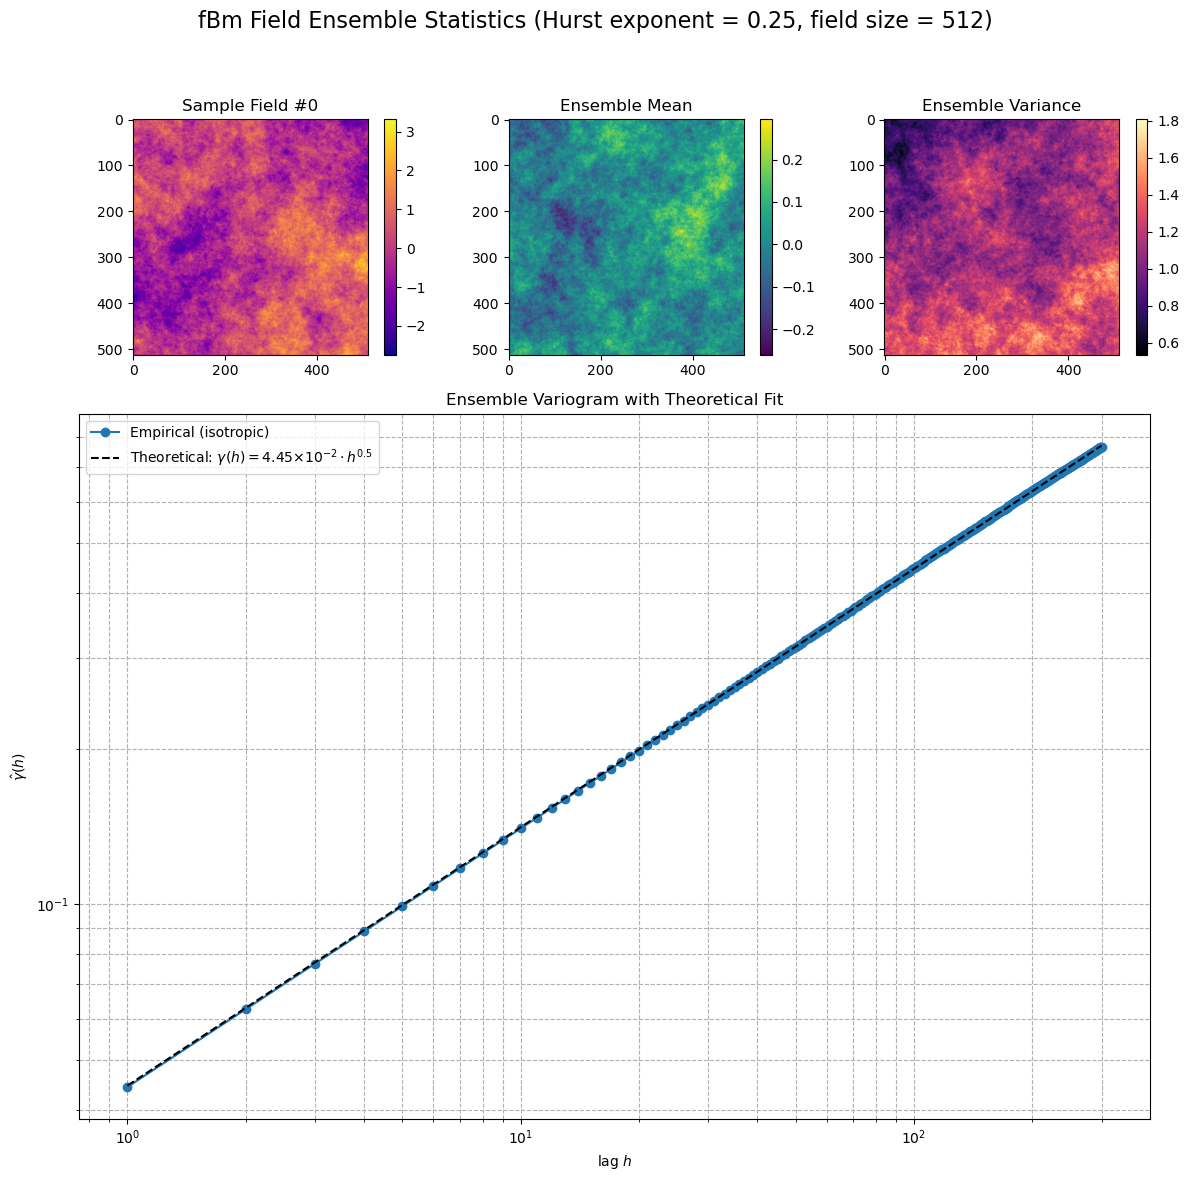

In [62]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Choose a sample field (e.g., first one)
sample_idx = 0
sample_field = fields[sample_idx]

# Set up figure with GridSpec: 2 rows, 3 columns
fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(2, 3, height_ratios=[1, 3])

# First row: 3 subplots
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])

# Second row: 1 subplot spanning all columns
ax4 = fig.add_subplot(gs[1, :])

# Plot 1: A sample realization
im0 = ax1.imshow(sample_field, cmap='plasma')
ax1.set_title(f"Sample Field #{sample_idx}")
fig.colorbar(im0, ax=ax1, fraction=0.046)

# Plot 2: Ensemble mean
im1 = ax2.imshow(mean_field, cmap='viridis')
ax2.set_title("Ensemble Mean")
fig.colorbar(im1, ax=ax2, fraction=0.046)

# Plot 3: Ensemble variance
im2 = ax3.imshow(var_field, cmap='magma')
ax3.set_title("Ensemble Variance")
fig.colorbar(im2, ax=ax3, fraction=0.046)

# Plot 4: Ensemble variogram (full-width)
ax4.loglog(lags, gamma_iso, 'o-', label="Empirical (isotropic)")
ax4.loglog(lags, gamma_theory, 'k--', label=fr"Theoretical: $\gamma(h) = {mantissa} × 10^{{{int(exponent)}}} \cdot h^{{{alpha}}}$")
ax4.set_xlabel("lag $h$")
ax4.set_ylabel(r"$\hat{\gamma}(h)$")
ax4.set_title("Ensemble Variogram with Theoretical Fit")
ax4.legend()
ax4.grid(True, which="both", ls="--")

# Super title
plt.suptitle(f"fBm Field Ensemble Statistics (Hurst exponent = {alpha/2}, field size = {num_pt})", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for suptitle
plt.savefig(f'stats_hurst{alpha/2}_size{num_pt}.pdf', format='pdf')
plt.show()
